In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import matplotlib
import seaborn as sns 

In [4]:
#torch.manual_seed(1)

In [5]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=False)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

train_dataset size: 60000 
test_dataset size: 10000


In [6]:
# Data loader func
def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader


def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader

In [7]:
class DNN(nn.Module):
    def __init__(self,):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc3 = nn.Linear(500, 10)

    def forward(self, x):
        # flatten as one dimension
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
      

        x = self.fc3(x)
        return x

In [8]:
#train function
def trainFunc(model,num_epochs,train_batch_size,status_interval):
    model.train()
    print('strated')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    epoch = 0
    modelParamWgt={}
    trainAvgLossArr = []
    trainAvgAccArr = []
    firstParaWgt = {}
    for epoch in range (num_epochs):
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum =0
        totalacc=0

        for i, (images, labels) in enumerate(train_load):  
            #if (i+1)% 60 == 0 : print(i+1)
            images, labels = Variable(images),Variable(labels)
            
            optimizer.zero_grad()
            
            # Forward pass
            prediction = model(images)

            images.requires_grad = True

            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()

            # Backward and optimize
            
            loss.backward()

            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            totalacc += acc

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)
            
            # #Weight Collection
            # if epoch % 3 == 0:
            #     for name, parameter in model.named_parameters():
            #         #print(name)
            #         if'weight' in name:
            #             modelParamWgt[epoch] = torch.nn.utils.parameters_to_vector(parameter).detach().numpy()
            #             print(modelParamWgt)

            #Print Status
            if (i+1) % status_interval == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\r',flush = True)
        
        #Weight Collection
        for name, parameter in model.named_parameters():
            #print(name)
            if'weight' in name:
                modelParamWgt[epoch] = torch.nn.utils.parameters_to_vector(parameter).detach().numpy()
                #print(modelParamWgt)       

        #1st Layer collection
        for name, parameter in model.named_parameters():
            if'fc1' in name and 'weight' in name:
                firstParaWgt[epoch] = torch.nn.utils.parameters_to_vector(parameter).detach().numpy()
                #print(firstParaWgt)
                        
        epochLoss = lossSum/(i+1)
        epochAcc = totalacc/(i+1)
        #print("Train Avg loss:",trainAvgLoss)
        trainAvgLossArr.append(epochLoss)    
        trainAvgAccArr.append(epochAcc)
                       
    return train_epoch,train_losses,train_acc,trainAvgLossArr,trainAvgAccArr, modelParamWgt,firstParaWgt

In [9]:
def testFunction(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss}',end= '\r',flush = True)
    return netTest_acc1, netTest_loss

In [10]:
def pcaOps(paramDF,itr):
    pcaOperation =  PCA(n_components=2)

    # scale = StandardScaler()

    # sData = scale.fit_transform(paramDF)

    pcaVal = pcaOperation.fit_transform(paramDF)

    itrData = np.full((pcaVal.shape[0],1),itr)

    #pcaDf = pd.DataFrame(data = pcaVal, columns = ['x','y'])

    pcaDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    return pcaDf


In [11]:
a=[]
tempModel = DNN()
for i in tempModel.parameters():
    a.append(torch.numel(i))
print(f'Total no of parameters:{np.sum(a)}')

Total no of parameters:397510


In [12]:
#2nd Approach

max_epochs = 45
all_df = pd.DataFrame()
columns=["x","y","Times"]
trainAllacc={}
testAllacc={}
trainAllloss={}
testAllloss={}
train_batch_size = 100
test_batch_size = 100
status_interval = 50
loss_func = nn.CrossEntropyLoss()
firstLayer = pd.DataFrame()

for count in range(8):
    print("Time: "+str(count))
    M = DNN()
    optimizer = torch.optim.Adam(M.parameters(),lr = 0.0004,weight_decay=1e-4)
    model_name1 = "Times: "+str(count)    
    train_epoch,train_losses,train_acc,trainAvgLoss,trainAvgAccArr, modelParamWgt,firstParamWgt = trainFunc(M,max_epochs,train_batch_size,status_interval)
    testAcc, testLoss = testFunction(M,loss_func,test_batch_size)

    temp_df = pd.DataFrame(modelParamWgt).transpose()
    all_df = all_df.append(temp_df)
    
    firstdf = pd.DataFrame(firstParamWgt).transpose()
    firstLayer = firstLayer.append(firstdf)

    testAllacc[count] = testAcc
    trainAllloss[count] = trainAvgLoss
    testAllloss[count] = testLoss
    trainAllacc[count] = trainAvgAccArr





Time: 0
strated
Time: 1y of the network on the test images: 98.21% & Test Loss: 0.05452080353352358
strated
Time: 2y of the network on the test images: 98.1% & Test Loss: 0.056439700524060755
strated
Time: 3y of the network on the test images: 98.1% & Test Loss: 0.0586241150310525
strated
Time: 4y of the network on the test images: 98.17% & Test Loss: 0.056799113195665996
strated
Time: 5y of the network on the test images: 98.27% & Test Loss: 0.05349340910215687
strated
Time: 6y of the network on the test images: 98.19% & Test Loss: 0.05552020461494976
strated
Time: 7y of the network on the test images: 98.21% & Test Loss: 0.05433790982940991
strated


In [13]:
trainAccArr = []
for key,values in enumerate(trainAllacc):
    trainAccArr.append(trainAllacc[key])
trainLossArr = []
for key,values in enumerate(trainAllloss):
    trainLossArr.append(trainAllloss[key])


In [14]:
    all_df

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
1,0.045037,-0.053748,-0.004241,-0.056903,-0.011714,0.007826,0.028594,0.018942,-0.010210,7.960875e-02,...,0.026395,0.051757,0.055158,0.051011,-0.098997,0.009302,-0.081231,0.034692,-0.040185,0.054413
2,0.048256,-0.069295,0.000345,-0.062783,-0.023636,0.020850,0.031746,0.017892,0.009022,8.910041e-02,...,0.038288,0.049943,0.052080,0.054730,-0.133657,0.007775,-0.115668,0.036693,-0.042299,0.109224
3,0.047298,-0.079428,0.006054,-0.067299,-0.043646,0.028328,0.031538,0.016004,0.029966,9.186415e-02,...,0.040866,0.049503,0.047388,0.059549,-0.166836,0.007045,-0.148805,0.037485,-0.051611,0.134683
4,0.048715,-0.080267,0.014648,-0.068319,-0.070426,0.034017,0.035070,0.016092,0.053226,9.624135e-02,...,0.044609,0.051375,0.044877,0.061932,-0.187522,0.005409,-0.171902,0.040299,-0.058145,0.149365
5,0.049277,-0.080222,0.013639,-0.070754,-0.094084,0.037014,0.038184,0.015835,0.069004,1.006976e-01,...,0.047274,0.054726,0.044460,0.064618,-0.210041,0.008488,-0.189119,0.042275,-0.064368,0.158447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,0.042768,0.072888,-0.069557,0.024206,0.022654,0.174918,0.129316,-0.026282,0.080710,7.713491e-08,...,-0.277408,-0.881020,0.247084,0.050149,0.142251,0.001862,0.143243,-0.794719,-0.241229,-0.378208
42,0.043267,0.073023,-0.063145,0.029047,0.019814,0.176921,0.132379,-0.025895,0.080129,7.729863e-10,...,-0.284170,-0.882690,0.245342,0.048163,0.139722,0.000839,0.142308,-0.802619,-0.241914,-0.377495
43,0.044363,0.076577,-0.061573,0.031137,0.016948,0.176545,0.131873,-0.032620,0.079201,1.272907e-12,...,-0.281486,-0.889977,0.245780,0.047996,0.147490,0.000285,0.141106,-0.803264,-0.243081,-0.381416
44,0.046454,0.074540,-0.059790,0.030136,0.011686,0.175691,0.135737,-0.029169,0.080103,1.459696e-16,...,-0.281991,-0.900167,0.242733,0.047658,0.148025,0.000066,0.140769,-0.809124,-0.241660,-0.388142


In [15]:
train_acc_df = pd.DataFrame(trainAccArr)
train_acc_data = np.array(train_acc_df).flatten()

train_loss_df = pd.DataFrame(trainLossArr)
train_loss_data = np.array(train_loss_df).flatten()

print(f'Shape of Loss:{np.shape(train_loss_data)} & Shape of Acc: {np.shape(train_acc_data)}')


Shape of Loss:(360,) & Shape of Acc: (360,)


In [16]:
t1 = all_df
print(pd.DataFrame(t1))

        0         1         2         3         4         5         6     \
1   0.045037 -0.053748 -0.004241 -0.056903 -0.011714  0.007826  0.028594   
2   0.048256 -0.069295  0.000345 -0.062783 -0.023636  0.020850  0.031746   
3   0.047298 -0.079428  0.006054 -0.067299 -0.043646  0.028328  0.031538   
4   0.048715 -0.080267  0.014648 -0.068319 -0.070426  0.034017  0.035070   
5   0.049277 -0.080222  0.013639 -0.070754 -0.094084  0.037014  0.038184   
..       ...       ...       ...       ...       ...       ...       ...   
41  0.042768  0.072888 -0.069557  0.024206  0.022654  0.174918  0.129316   
42  0.043267  0.073023 -0.063145  0.029047  0.019814  0.176921  0.132379   
43  0.044363  0.076577 -0.061573  0.031137  0.016948  0.176545  0.131873   
44  0.046454  0.074540 -0.059790  0.030136  0.011686  0.175691  0.135737   
45  0.046096  0.077850 -0.059339  0.027405  0.012079  0.175776  0.138286   

        7         8             9     ...      4990      4991      4992  \
1   0.018942

In [29]:
t1 = np.array(t1)
pca = PCA(n_components=2)
new_data = pca.fit_transform(t1)
# scaling=StandardScaler()
# scaled_data = scaling.fit_transform(new_data)

allEpochDf = pd.DataFrame(new_data,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

allEpochDf['Epoch']=eps_each_time
allEpochDf['Iteration']=(times)
allEpochDf["Acc"] = train_acc_data
allEpochDf["Loss"] = train_loss_data

allEpochDf


,x,y,Epoch,Iteration,Acc,Loss
0,1.614974,0.206166,0,0,83.330069,0.414050
1,2.071500,0.257423,1,0,94.158724,0.189511
2,2.454973,0.307018,2,0,95.945951,0.136041
3,2.780882,0.350229,3,0,97.135040,0.105064
4,3.079306,0.391214,4,0,97.535435,0.085865
...,...,...,...,...,...,...
355,1.472539,7.327291,40,7,99.956323,0.009185
356,1.477313,7.342042,41,7,99.942344,0.009171
357,1.479453,7.362409,42,7,99.914591,0.010224
358,1.481344,7.372562,43,7,99.951180,0.008499


In [18]:
epoch3Df = allEpochDf.loc[(allEpochDf['Epoch']+1)%3 == 0]
epoch3Df = epoch3Df.reset_index(drop=True)
epoch3Df

,x,y,Epoch,Iteration,Acc,Loss
0,2.454975,0.306971,2,0,95.945951,0.136041
1,3.349288,0.429391,5,0,98.032613,0.071242
2,4.069622,0.541522,8,0,98.882108,0.046062
3,4.686709,0.634659,11,0,99.272098,0.032111
4,5.211588,0.720628,14,0,99.581009,0.023657
...,...,...,...,...,...,...
115,1.433176,7.078428,32,7,99.912351,0.010302
116,1.460772,7.187140,35,7,99.903262,0.009717
117,1.472961,7.278070,38,7,99.935092,0.009758
118,1.477402,7.342155,41,7,99.942344,0.009171


In [19]:
test = np.array(epoch3Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))
len(mv)

120

In [56]:
cmap = ['red','blue','purple','green','yellow','brown','black','grey']

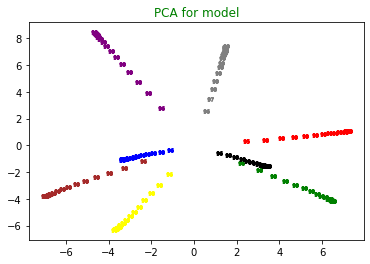

In [57]:
for i in range(len(mv)):
    m = mv[i]
    # colors = epoch3Df ['Iteration'][i]
    c = epoch3Df['Iteration'][i]
    plt.scatter(epoch3Df['x'][i],epoch3Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for model",color="g")


plt.savefig('D:/Clemson/COURSE/SEM-2/CPSC-8430 Deep Learning - 001/Homework/CPSC-8430-Deep-Learning-001/HW1/plots/PCA_1Copy.jpg',
            format='jpeg',
            dpi=700,
            bbox_inches='tight')

plt.show()

In [58]:
epoch1stEpoch= allEpochDf.loc[(allEpochDf['Epoch']+1) == 1]
epoch1stEpoch = epoch1stEpoch.reset_index(drop=True)
epoch1stEpoch

,x,y,Epoch,Iteration,Acc,Loss
0,1.614974,0.206166,0,0,83.330069,0.414050
1,-0.734126,-0.215128,0,1,83.198791,0.414224
2,-0.946631,1.804389,0,2,82.424782,0.417762
3,1.455073,-0.821092,0,3,82.988265,0.410153
4,-0.759072,-1.358337,0,4,82.693366,0.417513
5,-1.548343,-0.768222,0,5,83.998883,0.410682
6,0.783630,-0.342411,0,6,83.266180,0.411777
7,0.393477,1.703477,0,7,81.752646,0.415491


In [59]:
test = np.array(epoch1stEpoch.Acc)
fl = []
for i in range(len(test)):
    fl.append(str(int(test[i])))
len(fl)

8

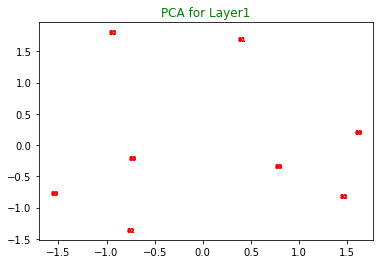

In [61]:
for i in range(len(fl)):
    m = fl[i]
    c = epoch3Df['Iteration'][i]
    plt.scatter(epoch1stEpoch['x'][i],epoch1stEpoch['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for Layer1",color="g")

plt.savefig('D:/Clemson/COURSE/SEM-2/CPSC-8430 Deep Learning - 001/Homework/CPSC-8430-Deep-Learning-001/HW1/plots/PCA_Layer1.jpg',
            format='jpeg',
            dpi=700,
            bbox_inches='tight')

plt.show()

In [64]:
tF = firstdf

tF = np.array(tF)
pca = PCA(n_components=2)
new_data2 = pca.fit_transform(tF)

firstLayDf = pd.DataFrame(new_data2,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

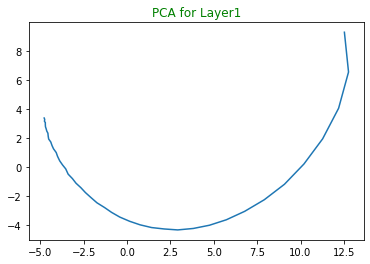

In [65]:
plt.plot(firstLayDf['x'],firstLayDf['y'])
plt.title("PCA for Layer1",color="g")

plt.savefig('D:/Clemson/COURSE/SEM-2/CPSC-8430 Deep Learning - 001/Homework/CPSC-8430-Deep-Learning-001/HW1/plots/PCA_Layer1_2.jpg',
            format='jpeg',
            dpi=700,
            bbox_inches='tight')

plt.show()